In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn import metrics
import scipy as sp
from scipy.spatial import distance_matrix

from diffusion_functions import *
from semi_supervised_manifold_learning import *
from yelp_restaurant_clustering import *
from animate_diffusion import animate_diffusion

# commands for displaying animations in jupyter notebook
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

In [ ]:
def format_axes(ax, titlestring):
    # figure formatting
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axis('off')
    if not titlestring==None:
        ax.set_title(titlestring)
    return

def plot_label_comparison_colorful(ax, label_vector, data_matrix, titlestring=None):
    threshold = 0 
    label_estimates = label_vector#make_sweep_cut(label_vector, threshold)

    im = ax.scatter(data_matrix[:,0],data_matrix[:,1],c=label_estimates)
    plt.colorbar(im, ax=ax)
    
    format_axes(ax,titlestring)
    return

def plot_label_comparison_binary(ax, label_vector, data_matrix, titlestring=None, 
                                 objective_function = sweep_cut_classification_error):
    
    cut_val, threshold = find_min_sweepcut(label_vector,100,objective_function, orthogonality_constraint = 'auto')
    label_estimates = make_sweep_cut(label_vector, threshold)
    
    classification_error = sweep_cut_classification_error(label_estimates)
    orthogonality_error = np.abs(np.sum(label_estimates)/len(label_estimates))

    im = ax.scatter(data_matrix[:,0],data_matrix[:,1],c=label_estimates)
    plt.colorbar(im, ax=ax)
    
    subtitle = f'\n Threshold = {threshold:.3f}. Cut objective = {cut_val:.3f} \n Class. error = {classification_error:.3f} \n Orthog. error = {orthogonality_error:.3f}'
    format_axes(ax,titlestring+subtitle)
    return

def compare_ROC_curves(hypergraph_x, graph_x, iteration_number):
    n = len(hypergraph_x[iteration_number, :])
    labels = np.hstack([np.full(shape=int(n/2),fill_value = -1),np.full(shape=int(n/2),fill_value = 1)])
    
    plt.plot(figsize=(15, 15))
    for x, legend_val in [(hypergraph_x[iteration_number, :], 'hypergraph'),
                          (graph_x[iteration_number, :], 'graph')]:
        fpr, tpr, thresholds = metrics.roc_curve(labels, x, pos_label=1)
        plt.plot(fpr, tpr, label = legend_val)
    
    graph_auc_score = metrics.roc_auc_score(labels, graph_x[iteration_number, :])
    hypergraph_auc_score = metrics.roc_auc_score(labels, hypergraph_x[iteration_number, :])
    
    plt.legend()
    plt.title('ROC curves at iteration '+str(iteration_number)+' \n hyper AUC score = '+str(hypergraph_auc_score)+' \n graph AUC score = '+str(graph_auc_score))
    plt.show()
    return

Visualizations

In [ ]:
k = 5
iterations_to_plot = [0, 5, 20, 100]
diffusion_step_size = 1
num_trials = 50

# generate new data
_,data_matrix = generate_overlapping_rings(r_1 = 2, r_2 = 2, n_pts = 300, x_shift = 2, 
                                           y_shift = 0, noise_level = 0.2, verbose = False)

# build graph/hypergraph
knn_adj_matrix = build_knn_graph(data_matrix,k)
knn_hgraph_dict = build_knn_hypergraph(data_matrix,k)

# run diffusion
max_iterations_needed = max(iterations_to_plot)+1
hypergraph_diff_results, graph_diff_results = semi_superivsed_knn_clustering(knn_adj_matrix,
                knn_hgraph_dict, num_iterations = max_iterations_needed, verbose = False)

hypergraph_x = hypergraph_diff_results['x']
graph_x = graph_diff_results['x']
    
for iternum in iterations_to_plot:
    fig_colorful, ax_colorful = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
    fig_binary, ax_binary = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
    for idx,(x,titlestring,objective) in enumerate([(graph_x[iternum],'Graph \n iteration '+str(iternum),graph_diff_results['objective']), 
            (hypergraph_x[iternum],'Hypergraph \n iteration '+str(iternum),hypergraph_diff_results['objective'])]):
        # first plot colorful
        plot_label_comparison_colorful(ax_colorful[idx],x, data_matrix,titlestring)
        # then plot binary
        plot_label_comparison_binary(ax_binary[idx],x, data_matrix,titlestring, objective_function = objective)
    plt.show()
    compare_ROC_curves(hypergraph_x, graph_x,iteration_number = iternum)


AUC Histograms

In [ ]:
k = 5
iterations_to_plot = [100]
diffusion_step_size = 1
num_trials = 10

for rad_val in [2, 5, 10]:
    AUC_vals = []
    for trial in range(num_trials):
        # generate new data
        _,data_matrix = generate_overlapping_rings(r_1 = 2, r_2 = rad_val, n_pts = 300, x_shift = rad_val, 
                                                   y_shift = 0, noise_level = 0.2, verbose = False)

        # build graph/hypergraph
        knn_adj_matrix = build_knn_graph(data_matrix,k)
        knn_hgraph_dict = build_knn_hypergraph(data_matrix,k)

        # run diffusion
        max_iterations_needed = max(iterations_to_plot)
        hypergraph_diff_results, graph_diff_results = semi_superivsed_knn_clustering(knn_adj_matrix,
                        knn_hgraph_dict, num_iterations = max_iterations_needed, verbose = False)

        hypergraph_x = hypergraph_diff_results['x']
        graph_x = graph_diff_results['x']

        n = data_matrix.shape[0]
        labels = np.hstack([np.full(shape=int(n/2),fill_value = -1),np.full(shape=int(n/2),fill_value = 1)])
        graph_auc_score = metrics.roc_auc_score(labels, graph_x[-1, :])
        hypergraph_auc_score = metrics.roc_auc_score(labels, hypergraph_x[-1, :])

        AUC_vals.append((hypergraph_auc_score, graph_auc_score))

    plt.hist([v[0] for v in AUC_vals], bins = 20, alpha=0.5, label='hypergraph')
    plt.hist([v[1] for v in AUC_vals], bins = 20, alpha=0.5, label = 'graph')
    plt.title(f'AUC vals at iteration {max_iterations_needed} \n r_2 = x-shift = {rad_val} \n {num_trials} trials')
    plt.legend()
    plt.show()
    
    if False:
        # plot example from last iteration
        iternum = max(iterations_to_plot)-1
        fig_binary, ax_binary = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
        for idx,(x,titlestring,objective) in enumerate([(graph_x[iternum],'Graph \n iteration '+str(iternum),graph_diff_results['objective']), 
                (hypergraph_x[iternum],'Hypergraph \n iteration '+str(iternum),hypergraph_diff_results['objective'])]):
            plot_label_comparison_binary(ax_binary[idx],x, data_matrix,titlestring, objective_function = objective)
        plt.show()
        compare_ROC_curves(hypergraph_x, graph_x,iteration_number = iternum)

    
    

# Hyphersphere examples:
 
Dim versus identifiability

In [2]:
def plot_AUC_hist(AUC_vals, titlestring = None):
    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (12, 5))
    # first style
    _, first_bins, _ = axes[0].hist([[v[1] for v in AUC_vals], [v[0] for v in AUC_vals]], edgecolor = 'black', label=['graph', 'hypergraph'])
    axes[0].legend()
    #axes[0].set_title(f'STYLE 1 \nAUC vals for {problem_kind} at iteration {max_iterations_needed} \n {num_trials} trials')

    # second style
    axes[1].hist([v[1] for v in AUC_vals], bins = first_bins, alpha=0.5, edgecolor = 'black', label = 'graph')
    axes[1].hist([v[0] for v in AUC_vals], bins = first_bins, alpha=0.5, edgecolor = 'black', label='hypergraph')
    axes[1].legend()
    #axes[1].set_title(f'STYLE 2 \nAUC vals for {problem_kind} at iteration {max_iterations_needed} \n {num_trials} trials')
    
    # figure formatting
    for ax in axes:
        ax.set_title(titlestring)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis='x', labelsize=15)
        ax.tick_params(axis='y', labelsize=15)
    
    plt.show()

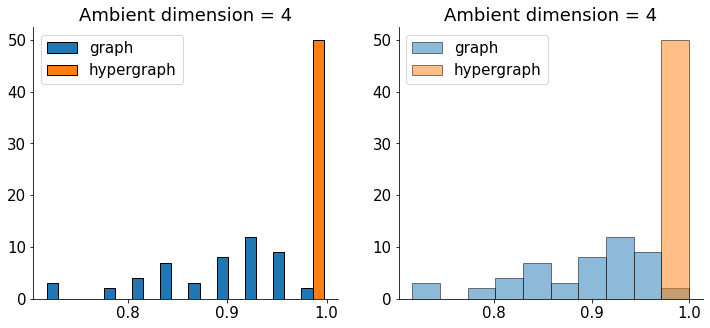

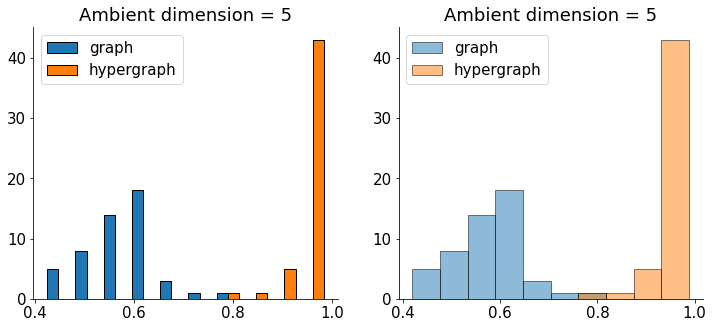

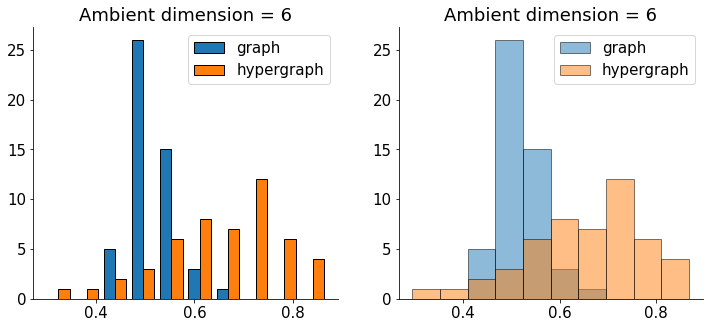

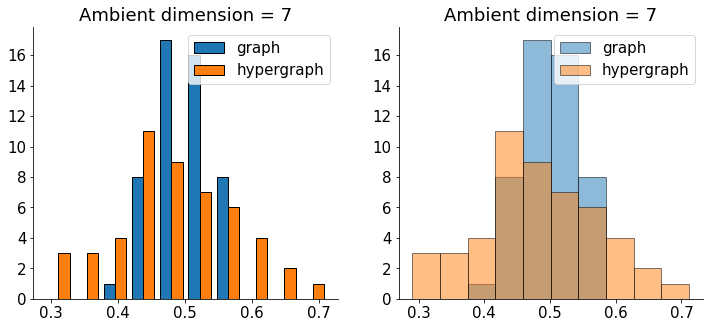

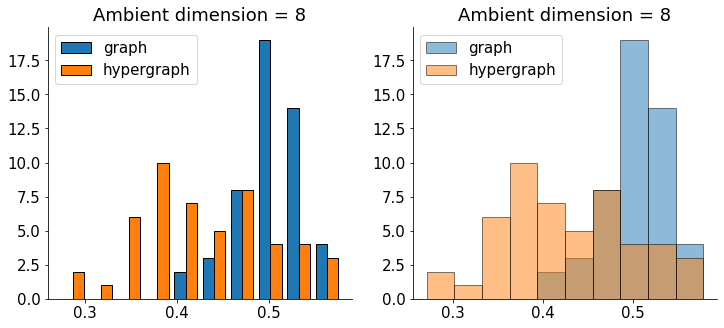

In [4]:
k = 5
iterations_to_plot = [50]
diffusion_step_size = 1
num_trials = 50

for ambient_dim in [4, 5, 6, 7, 8]:
    AUC_vals = []
    for trial in range(num_trials):
        # generate new data
        _, data_matrix = generate_concentric_highdim(ambient_dim = ambient_dim, verbose=False)

        # build graph/hypergraph
        knn_adj_matrix = build_knn_graph(data_matrix,k)
        knn_hgraph_dict = build_knn_hypergraph(data_matrix,k)

        # run diffusion
        max_iterations_needed = max(iterations_to_plot)
        hypergraph_diff_results, graph_diff_results = semi_superivsed_knn_clustering(knn_adj_matrix,
                        knn_hgraph_dict, num_iterations = max_iterations_needed, verbose = False)

        hypergraph_x = hypergraph_diff_results['x']
        graph_x = graph_diff_results['x']

        n = data_matrix.shape[0]
        labels = np.hstack([np.full(shape=int(n/2),fill_value = -1),np.full(shape=int(n/2),fill_value = 1)])
        graph_auc_score = metrics.roc_auc_score(labels, graph_x[-1, :])
        hypergraph_auc_score = metrics.roc_auc_score(labels, hypergraph_x[-1, :])

        AUC_vals.append((hypergraph_auc_score, graph_auc_score))
    plot_AUC_hist(AUC_vals,titlestring = f'Ambient dimension = {ambient_dim}') 

In [ ]:
def find_pairwise_dist(data_matrix, titlestring):
    plt.rcParams.update({'font.size': 10})
    
    com_size = int(data_matrix.shape[0]/2)
    M = distance_matrix(data_matrix, data_matrix)
    C1_block = M[:com_size,:com_size]
    ave_C1_in_dist = np.mean(C1_block[np.triu_indices_from(C1_block,k=1)])
    
    C2_block = M[com_size:,com_size:]
    ave_C2_in_dist = np.mean(C2_block[np.triu_indices_from(C2_block,k=1)])
    
    ave_btw_com_dist = np.mean(M[:com_size,com_size:])
    plt.imshow(M)
    plt.colorbar()
    plt.title(titlestring+ f'\n Ave in-community distance in outer shell = {ave_C1_in_dist:.2f} \n' 
              +f'ave in-community distance in inner sphere = {ave_C2_in_dist:.2f} \n'
             +f'ave dist btwn two communities = {ave_btw_com_dist:.2f}')
    plt.show()
    return

find_pairwise_dist(data_matrix,'')


In [ ]:
k = 5
iterations_to_plot = [50]
diffusion_step_size = 1

for ambient_dim in [2, 4, 6, 7, 8, 9, 10, 11, 20]:
    # generate new data
    _, data_matrix = generate_concentric_highdim(ambient_dim = ambient_dim, verbose=False)
    find_pairwise_dist(data_matrix,f'Dimension = {ambient_dim}')
    
    # I guess the question is: what fraction of pts in the k-nn is actually in-community?
    # build graph/hypergraph
    knn_adj_matrix = build_knn_graph(data_matrix,k)
    knn_hgraph_dict = build_knn_hypergraph(data_matrix,k)
    
    

    

300 nodes in each community:


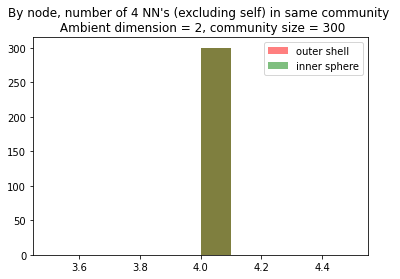

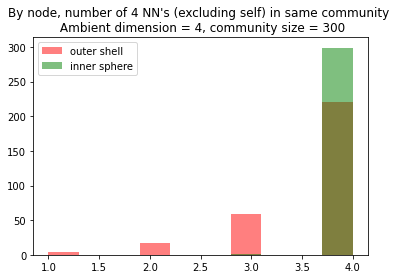

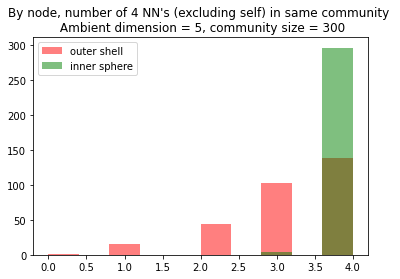

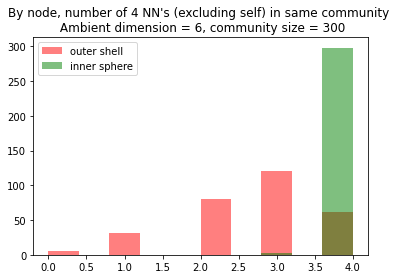

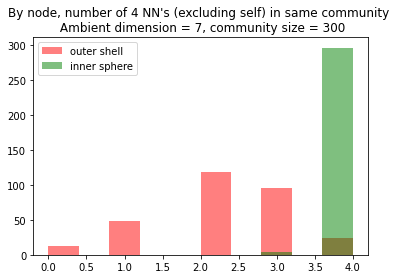

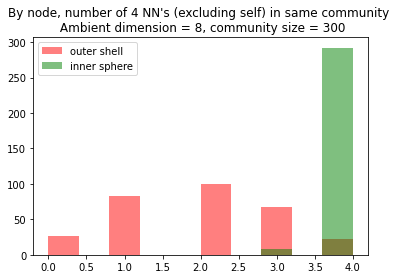

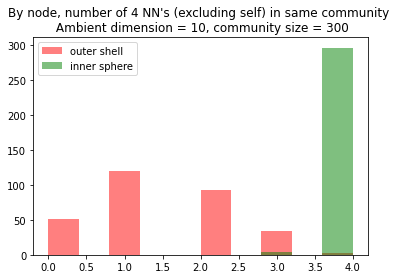

1000 nodes in each community:


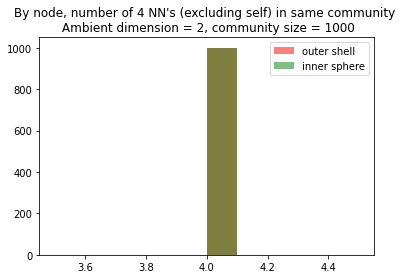

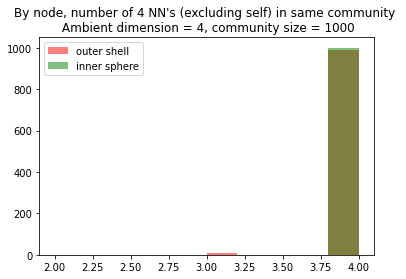

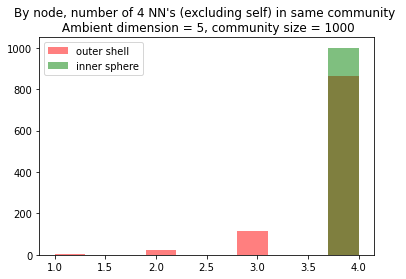

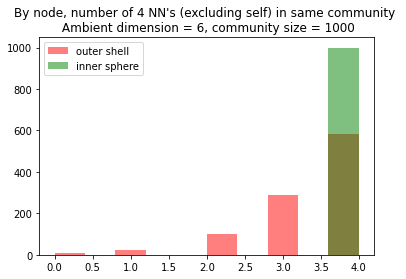

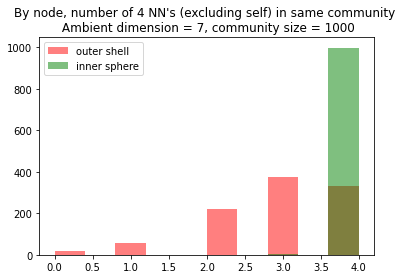

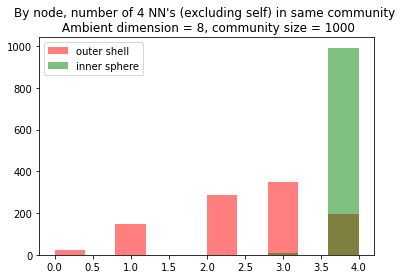

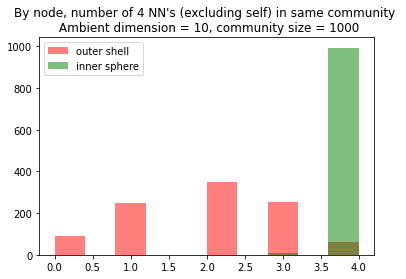

In [5]:
def com_ID(node_idx, community_size):
    return node_idx < community_size


k = 5
diffusion_step_size = 1


for community_size in [300, 1000]:
    print(f'{community_size} nodes in each community:')
    for ambient_dim in [2, 4, 5, 6, 7, 8, 10]:
        _, data_matrix = generate_concentric_highdim(ambient_dim = ambient_dim, n_pts = community_size,
                                                     verbose=False)
        #M = distance_matrix(data_matrix, data_matrix)

        # I guess the question is: what fraction of pts in the k-nn is actually in-community?
        # build graph/hypergraph
        knn_adj_matrix = build_knn_graph(data_matrix,k)
        knn_hgraph_dict = build_knn_hypergraph(data_matrix,k)

        hgraph = knn_hgraph_dict['hypergraph']
        C1_same_cluster_num = [sum([com_ID(v, community_size)==com_ID(e[0], community_size) 
                                    for v in e[1:]]) for e in hgraph[:community_size] ]
        C2_same_cluster_num = [sum([com_ID(v, community_size)==com_ID(e[0], community_size) 
                                    for v in e[1:]]) for e in hgraph[community_size:] ]

        _, dummy_bins, _ = plt.hist([C1_same_cluster_num, C2_same_cluster_num])
        plt.clf()

        # second style
        plt.hist(C1_same_cluster_num, bins = dummy_bins, alpha=0.5, color = 'r', label = 'outer shell')
        plt.hist(C2_same_cluster_num, bins = dummy_bins, alpha=0.5, color = 'g', label = 'inner sphere')
        plt.legend()


        plt.title(f'By node, number of {k-1} NN\'s (excluding self) in same community \n Ambient dimension = {ambient_dim}, community size = {community_size}')
        plt.show()
